
This project aims to guide individuals through the process of building and optimizing neural networks for binary and multi-class classification tasks. It covers fundamental concepts, data preparation, model training, and performance evaluation. Additionally, it delves into advanced techniques such as hyperparameter tuning, regularization, optimization algorithms, learning rate scheduling, and data augmentation to improve model performance. Practical implementation examples using frameworks like PyTorch is provided to offer hands-on experience. The goal is to equip learners with the knowledge and tools to effectively construct and enhance neural networks for various classification challenges.

## 1. Create Dataset 

In [2]:
import sklearn 
from sklearn.datasets import make_circles
import numpy as np

In [3]:
# Here we will use sklearn.datasets to import circle data 
number_sample = 1000
x, y = make_circles(number_sample, 
                   noise = 0.03,
                   random_state = 42)

In [4]:
print(f"First five sample of data{x[:5]}")
print(f"First five sample of label{y[:5]}")

First five sample of data[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five sample of label[1 1 1 1 0]


In [5]:
import pandas as pd
circle = pd.DataFrame({"X1":x[:,0],
                       "X2":x[:,1],
                       "Y":y})
circle

,X1,X2,Y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


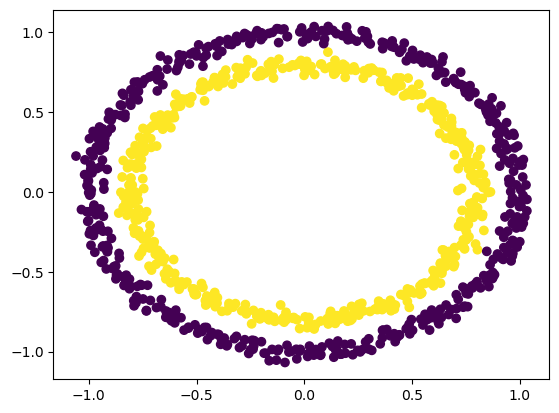

In [7]:
# Dataset are two circles
import matplotlib.pyplot as plt
plt.scatter(x=x[: , 0],
            y=x[: , 1],
           c = y
           )

#### 1.1 Check input and output shape

In [6]:
x.shape , y.shape

((1000, 2), (1000,))

In [7]:
X_sample = x[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


#### 1.2 Convert data into tensor

In [8]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [9]:
type(x)

numpy.ndarray

In [10]:
# Make sure they are the same kind of datatype, have to be float 32 and torch tensor
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)


In [11]:
print(x[:5])
print(y[:5])

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
tensor([1., 1., 1., 1., 0.])


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test , y_train, y_test = train_test_split(x,y,
                                                     test_size = 0.2,
                                                    random_state = 42)

## 2. Builld a model

In [14]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [15]:
# We will make a model solely based on linear function, assuming data is linear
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__( )
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1)
        
#         self.two_linear_layer = nn.Sequential(
#                                 nn.Linear(in_features = 2, out_features = 5),
#                                  nn.Linear(in_features = 5, out_features = 1)
#                                 )
    def forward(self,x):
        return self.layer_2(self.layer_1(x))
    

model_0 = CircleModelV0()
model_0
next(model_0.parameters())

Parameter containing:
tensor([[ 0.4030, -0.4369],
        [-0.0071, -0.6490],
        [ 0.5716,  0.6601],
        [-0.5967,  0.2080],
        [ 0.6230,  0.0889]], requires_grad=True)

In [17]:
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.2697],
        [0.2935],
        [0.2053],
        [0.2879],
        [0.2025],
        [0.2171],
        [0.2866],
        [0.2687],
        [0.2055],
        [0.2951]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Training the Model

In [18]:
# Loss Function 
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                           lr=0.1)

In [19]:
# We want to know how many items we are able to predict correctly
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train Model

### 3.1 Output without training 

In [20]:
# Output are the logit, we need to convert them using sigmoid , round it 
model_0.eval()
with torch.inference_mode():
    y_prediction = torch.round(torch.sigmoid(model_0(X_test)))
    
y_prediction.shape

torch.Size([200, 1])

In [21]:
# Check how many actually equals, turns out this is just a random guess
torch.eq(y_prediction.squeeze(), y_test.squeeze()).sum().item()

100

### 3.2 Training Loop 

In [22]:
epochs = 101

for epoch in range(epochs):
    # Training 
    model_0.train()
    
    # Forward Pass
    y_logit = model_0(X_train).squeeze()
    y_prediction = torch.round(torch.sigmoid(y_logit))
    
    # Loss and accuracy 
    # First loss is if BCE loss, second loss is BCEwithLogitLoss
    #loss = loss_fn(torch.sigmoid(y_logit), y_train)
    loss = loss_fn(y_logit, y_train)
    acc = accuracy_fn(y_train, y_prediction)
    
    # Optimizer
    optimizer.zero_grad()
    
    # Loss Backward
    loss.backward()
    
    # Optimize parameters
    optimizer.step()
    
    # Test
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_prediction = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_prediction)
    if epoch % 10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69996, Accuracy: 50.00% | Test loss: 0.70140, Test acc: 50.00%
Epoch: 10 | Loss: 0.69596, Accuracy: 50.00% | Test loss: 0.69734, Test acc: 50.00%
Epoch: 20 | Loss: 0.69435, Accuracy: 50.00% | Test loss: 0.69564, Test acc: 50.00%
Epoch: 30 | Loss: 0.69368, Accuracy: 53.12% | Test loss: 0.69493, Test acc: 53.00%
Epoch: 40 | Loss: 0.69340, Accuracy: 54.25% | Test loss: 0.69464, Test acc: 53.50%
Epoch: 50 | Loss: 0.69326, Accuracy: 52.38% | Test loss: 0.69451, Test acc: 52.00%
Epoch: 60 | Loss: 0.69319, Accuracy: 52.12% | Test loss: 0.69447, Test acc: 48.00%
Epoch: 70 | Loss: 0.69314, Accuracy: 51.75% | Test loss: 0.69446, Test acc: 48.00%
Epoch: 80 | Loss: 0.69311, Accuracy: 51.62% | Test loss: 0.69446, Test acc: 50.00%
Epoch: 90 | Loss: 0.69308, Accuracy: 51.62% | Test loss: 0.69448, Test acc: 48.50%
Epoch: 100 | Loss: 0.69306, Accuracy: 51.50% | Test loss: 0.69449, Test acc: 47.50%


it shows that after epochs of training, the result hasn't improved much 

## 4. Investigate the model and see why it is not working 

### 4.1 Use function to plot decision boundary

In [23]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

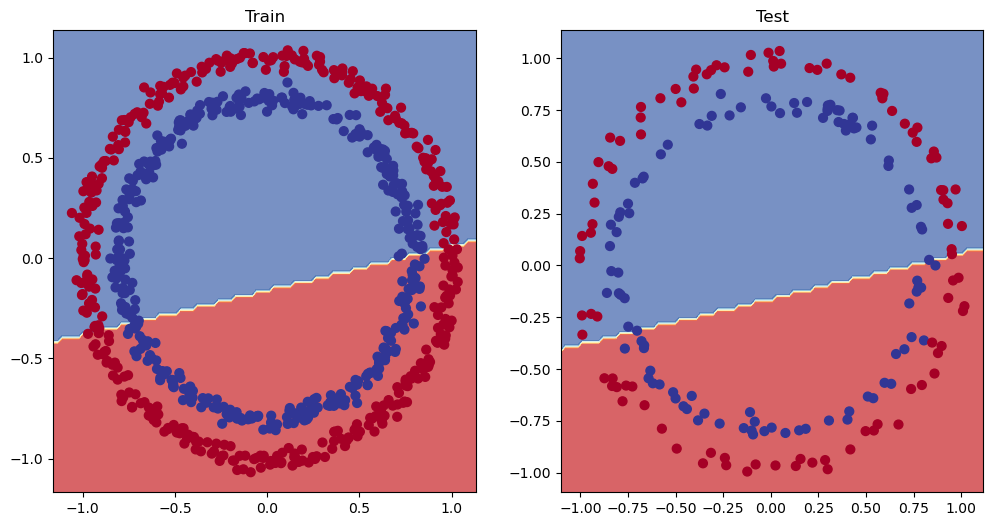

In [24]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0 , X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0 , X_test, y_test)

Since Neural Network is a bunch of linear layers, it should not surprise us that it is simply drawing a line to separate the two 

## 5. How to improve a model 

### 5.1  Ways to improve the Result\
Improve Model\
Work on Hyperparameters
1. More layer 
2. More neurons
3. More Epochs
4. Change Activation Function
5. Change Learning Rate
6. Change Loss Function

Improve dataset
1. Feature Engineering
2. Import large dataset 

### 5.2: Plans to improve the model \
Add more neurons : 5 to 10 \
Increase layers: 2 -> 4 \
Increase Training Epochs 100-> 500 

We implement changes one by one, and see change one leads us to greatest improvement 

## 6. Implementiaon of the model 

### 6.1 Implement the changes 

In [25]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__( )
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_4 = nn.Linear(in_features = 10, out_features = 1)
        
#         self.two_linear_layer = nn.Sequential(
#                                 nn.Linear(in_features = 2, out_features = 5),
#                                  nn.Linear(in_features = 5, out_features = 1)
#                                 )
    def forward(self,x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        z = self.layer_4(z)
        return z
    

model_1 = CircleModelV1()
model_1
next(model_1.parameters())

Parameter containing:
tensor([[ 0.5207,  0.2889],
        [-0.3038, -0.5837],
        [ 0.0689, -0.1944],
        [ 0.4906, -0.2292],
        [-0.5446, -0.2999],
        [ 0.3462, -0.0531],
        [ 0.5295, -0.1240],
        [-0.4740, -0.0838],
        [-0.4148,  0.0149],
        [ 0.6663, -0.1202]], requires_grad=True)

In [26]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5207,  0.2889],
                      [-0.3038, -0.5837],
                      [ 0.0689, -0.1944],
                      [ 0.4906, -0.2292],
                      [-0.5446, -0.2999],
                      [ 0.3462, -0.0531],
                      [ 0.5295, -0.1240],
                      [-0.4740, -0.0838],
                      [-0.4148,  0.0149],
                      [ 0.6663, -0.1202]])),
             ('layer_1.bias',
              tensor([-0.2157,  0.6612, -0.0377,  0.2317,  0.3725, -0.6273, -0.1599,  0.1720,
                       0.2849,  0.3831])),
             ('layer_2.weight',
              tensor([[-0.2150, -0.2061, -0.1786,  0.1506, -0.0609,  0.1691,  0.2151,  0.1099,
                       -0.1799, -0.1579],
                      [-0.2310, -0.2842, -0.2406,  0.0338,  0.0740, -0.3085, -0.3011, -0.2527,
                        0.2637,  0.0838],
                      [ 0.1617,  0.2795,  0.1322,  0.2403,  0.0887, -0.0

In [27]:
# Loss Function 
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                           lr=0.1)

In [28]:
torch.manual_seed(42)

In [29]:
epochs = 1001

for epoch in range(epochs):
    # Training 
    model_1.train()
    
    # Forward Pass
    y_logit = model_1(X_train).squeeze()
    y_prediction = torch.round(torch.sigmoid(y_logit))
    
    # Loss and accuracy 
    # First loss is if BCE loss, second loss is BCEwithLogitLoss
    #loss = loss_fn(torch.sigmoid(y_logit), y_train)
    loss = loss_fn(y_logit, y_train)
    acc = accuracy_fn(y_train, y_prediction)
    
    # Optimizer
    optimizer.zero_grad()
    
    # Loss Backward
    loss.backward()
    
    # Optimize parameters
    optimizer.step()
    
    # Test
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_prediction = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_prediction)
    if epoch % 50==0:
        print(f"Model_1: Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Model_1: Epoch: 0 | Loss: 0.69758, Accuracy: 50.00% | Test loss: 0.69833, Test acc: 50.00%
Model_1: Epoch: 50 | Loss: 0.69305, Accuracy: 49.00% | Test loss: 0.69396, Test acc: 48.50%
Model_1: Epoch: 100 | Loss: 0.69302, Accuracy: 50.75% | Test loss: 0.69402, Test acc: 45.50%
Model_1: Epoch: 150 | Loss: 0.69301, Accuracy: 50.50% | Test loss: 0.69410, Test acc: 46.00%
Model_1: Epoch: 200 | Loss: 0.69300, Accuracy: 50.50% | Test loss: 0.69417, Test acc: 48.00%
Model_1: Epoch: 250 | Loss: 0.69300, Accuracy: 50.88% | Test loss: 0.69423, Test acc: 46.50%
Model_1: Epoch: 300 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69429, Test acc: 47.00%
Model_1: Epoch: 350 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69434, Test acc: 46.00%
Model_1: Epoch: 400 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69438, Test acc: 46.00%
Model_1: Epoch: 450 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69442, Test acc: 46.00%
Model_1: Epoch: 500 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.6944

### 6.2 show the result 

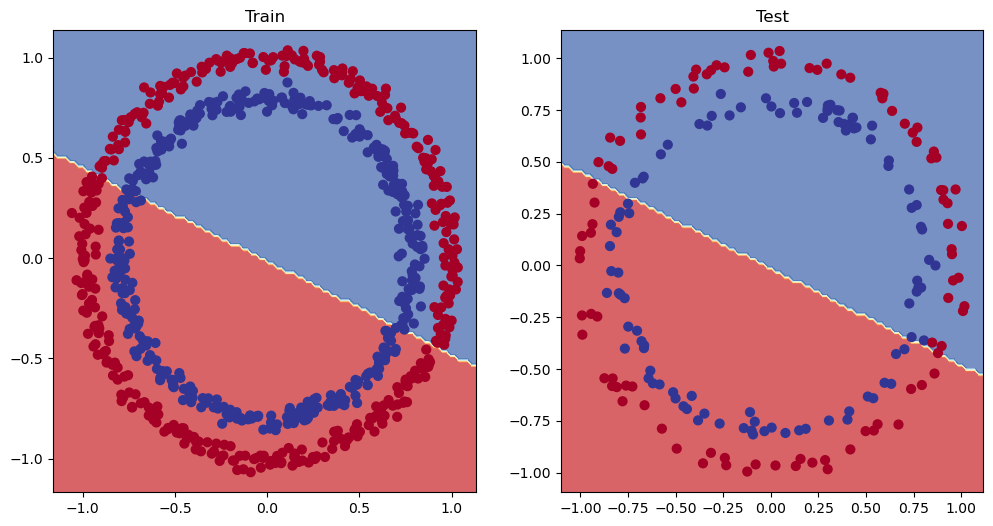

In [30]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1 , X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1 , X_test, y_test)

Model still not working, so this is not a problem of model complexity, we need to investigate more 

## 7. Investigate the Model, maybe the model is not able to learn anything ?

### 7.1 Create simple regressio problem, since if neural network is able to learn 

In [31]:

weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.01

X = torch.arange(start, end , step).unsqueeze(dim = 1)
y = weight * X + bias

# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:] 

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [33]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__( )
        self.layer_1 = nn.Linear(in_features = 1, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    def forward(self,x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z
    

model_2 = CircleModelV2()
model_2
next(model_2.parameters())

Parameter containing:
tensor([[ 0.7645],
        [ 0.8300],
        [-0.2343],
        [ 0.9186],
        [-0.2191],
        [ 0.2018],
        [-0.4869],
        [ 0.5873],
        [ 0.8815],
        [-0.7336]], requires_grad=True)

In [34]:
# Loss Function 
loss_fn = nn.L1Loss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_2.parameters(),
                           lr=0.1)
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    # Training 
#    model_2.train()
    
    y_pred = model_2(X_train)
    
    # Loss and accuracy 
    loss = loss_fn(y_pred, y_train)
    
    # Optimizer
    optimizer.zero_grad()
    
    # Loss Backward
    loss.backward()
    
    # Optimize parameters
    optimizer.step()
    
    # Test
    model_2.eval()
    with torch.inference_mode():
        test_prediction = model_2(X_test)
        
        test_loss = loss_fn(test_prediction, y_test)

    if epoch % 10==0:
        print(f"Model_2: Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")
    

Model_2: Epoch: 0 | Loss: 0.75986 | Test loss: 0.54143
Model_2: Epoch: 10 | Loss: 0.14550 | Test loss: 0.02363
Model_2: Epoch: 20 | Loss: 0.14420 | Test loss: 0.05597
Model_2: Epoch: 30 | Loss: 0.10136 | Test loss: 0.03785
Model_2: Epoch: 40 | Loss: 0.07525 | Test loss: 0.00984
Model_2: Epoch: 50 | Loss: 0.07625 | Test loss: 0.02102
Model_2: Epoch: 60 | Loss: 0.10320 | Test loss: 0.02754
Model_2: Epoch: 70 | Loss: 0.08643 | Test loss: 0.01007
Model_2: Epoch: 80 | Loss: 0.06937 | Test loss: 0.01326
Model_2: Epoch: 90 | Loss: 0.08678 | Test loss: 0.03027
Model_2: Epoch: 100 | Loss: 0.09309 | Test loss: 0.02901
Model_2: Epoch: 110 | Loss: 0.06735 | Test loss: 0.00973
Model_2: Epoch: 120 | Loss: 0.08538 | Test loss: 0.03464
Model_2: Epoch: 130 | Loss: 0.07850 | Test loss: 0.02388
Model_2: Epoch: 140 | Loss: 0.09153 | Test loss: 0.02218
Model_2: Epoch: 150 | Loss: 0.07135 | Test loss: 0.02059
Model_2: Epoch: 160 | Loss: 0.06966 | Test loss: 0.01357
Model_2: Epoch: 170 | Loss: 0.07144 | Test

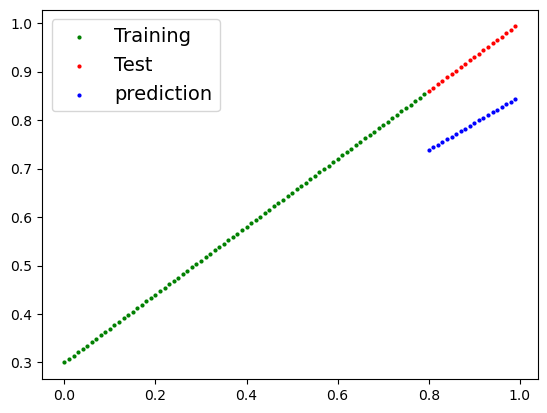

In [35]:
plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=test_prediction)

Here it shows that our model is actually able to learn, this means it has something to do with the data and model

## 8. Utililze Non-linearity

### 8.1 recreate the data

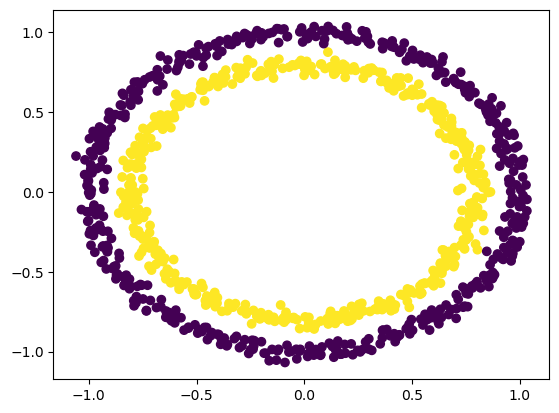

In [43]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
number_sample = 1000
x, y = make_circles(number_sample, 
                   noise = 0.03,
                   random_state = 42)
circle = pd.DataFrame({"X1":x[:,0],
                       "X2":x[:,1],
                       "Y":y})
circle

import matplotlib.pyplot as plt
plt.scatter(x=x[: , 0],
            y=x[: , 1],
           c = y
           )

x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test , y_train, y_test = train_test_split(x,y,
                                                     test_size = 0.2,
                                                    random_state = 42)

### 8.2 Build a new model using non-linear and train it

We will use relu function to make model non-linear,combine linearnity and nonlineanrity

In [44]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__( )
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        z = self.layer_1(x)
        z = self.relu(z)
        z = self.layer_2(z)
        z = self.relu(z)
        z = self.layer_3(z)
        return z

model_3 = CircleModelV2()
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [45]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [46]:
epochs = 1000
torch.manual_seed(42)

# Binary Classification
for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # Evaluete the test 
      test_logits = model_3(X_test).squeeze()
   
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
    
      test_loss = loss_fn(test_logits, y_test)
    
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


### 8.3 Evaluate Model

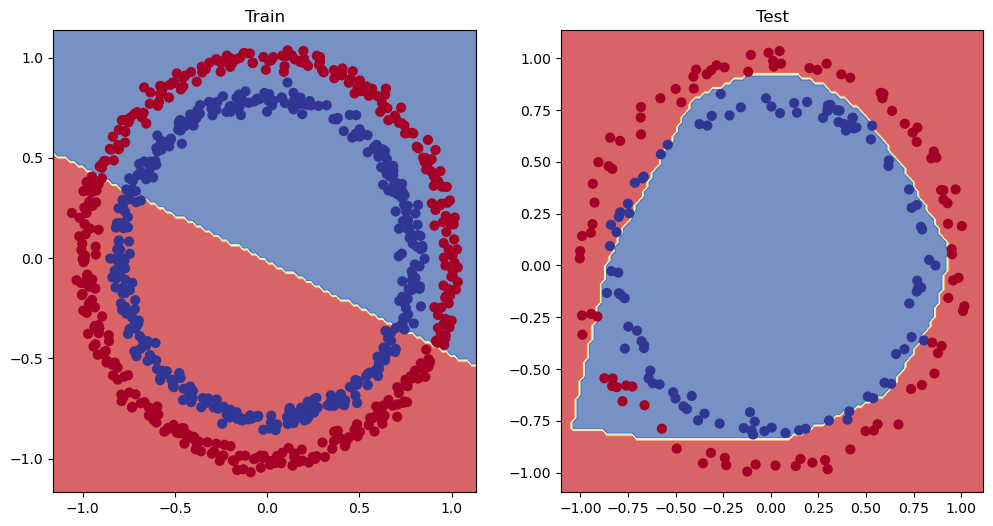

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

The decision boundary makes more sense now than the previous one 

### 8.4 Replicate the activation function 

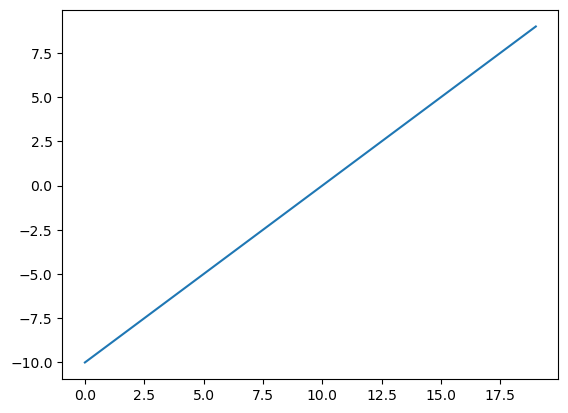

In [51]:
# Let's see how different activation function will shape the input data
A = torch.arange(-10, 10, 1)
plt.plot(A)

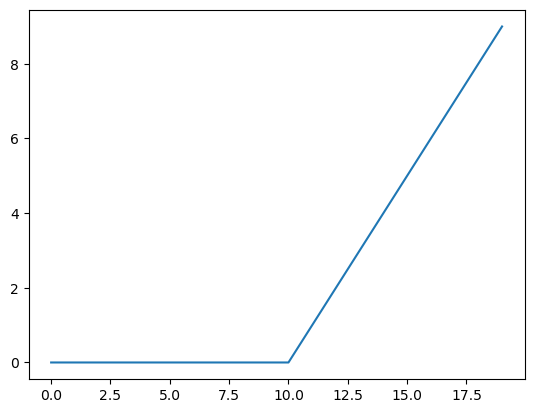

In [54]:
# relu activation function
def relu(x):
    return torch.maximum(torch.tensor(0), x)
plt.plot(relu(A))

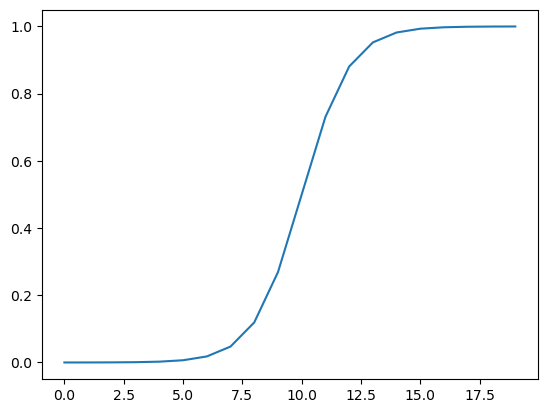

In [56]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
plt.plot(sigmoid(A))

## 9. Multi Class Classification Problem 

### 9.1 Create dataset

In [57]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

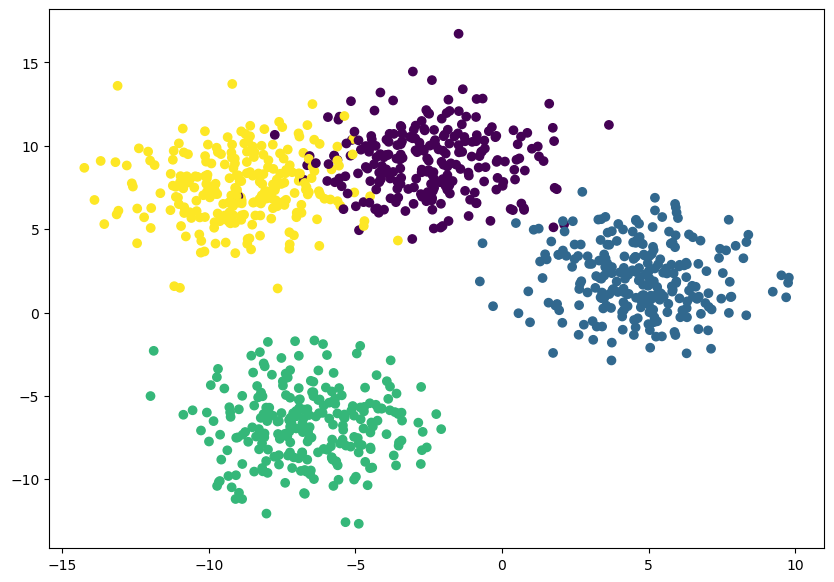

In [83]:
Numer_Class = 4
Numer_Feature = 2
Random_Seed = 42

# Create data
X , y = make_blobs(n_samples = 1000,
                  n_features = Numer_Feature,
                  centers = Numer_Class,
                  cluster_std = 2,
                  random_state = Random_Seed)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2,
    random_state=Random_Seed
)


plt.figure(figsize = (10,7))
plt.scatter(X[: ,0], X[:,1], c = y)

### 9.2 Create the model

In [120]:
class BlobModel(nn.Module):
    def __init__(self, input_features, out_features, hidden_unit):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_unit),
    #    nn.ReLu()# Incase we need non-linearnity
        nn.Linear(in_features = hidden_unit, out_features = hidden_unit),
    #    nn.ReLu()#In case we need non-linearnity
        nn.Linear(in_features = hidden_unit, out_features = out_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features = X.shape[1],
                    out_features = len(torch.unique(y)),
                    hidden_unit = 8
                    
)
model_4.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('linear_layer_stack.1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.276

In [93]:
# These are logits, we need to convert them into predicted probability
model_4.eval()

with torch.inference_mode():
    y_preds = model_4(X_test)
y_preds

tensor([[-0.9541, -0.0610, -0.3977,  0.5782],
        [ 0.0470,  0.1555, -0.7129,  0.0815],
        [ 0.9427,  0.4809, -0.0529, -1.3076],
        [-0.5297,  0.0716, -0.2395,  0.0749],
        [-0.9614, -0.1052, -0.7002,  0.8875],
        [ 0.1634,  0.1713, -0.8165,  0.0909],
        [ 0.7929,  0.4549,  0.0396, -1.2788],
        [-0.6157, -0.0142, -0.6928,  0.5994],
        [ 1.2586,  0.5492, -0.1525, -1.4641],
        [-0.7291, -0.0426, -0.6849,  0.6835],
        [-0.4269,  0.0365, -0.6811,  0.4344],
        [-1.0956, -0.0960, -0.3845,  0.6799],
        [-0.8901, -0.0894, -0.7196,  0.8491],
        [-0.7691, -0.0648, -0.7692,  0.8006],
        [-0.8802, -0.0992, -0.8082,  0.9299],
        [-0.1069,  0.1197, -0.6823,  0.1758],
        [ 0.0864,  0.1644, -0.7221,  0.0587],
        [ 0.4432,  0.3206, -0.2699, -0.6844],
        [-0.0681,  0.1081, -0.8370,  0.2995],
        [ 0.2940,  0.2307, -0.6351, -0.1971],
        [-0.1926,  0.0866, -0.7592,  0.3226],
        [-0.4383,  0.0467, -0.5876

In [98]:
torch.softmax(y_preds,dim=1)

tensor([[0.1019, 0.2488, 0.1777, 0.4716],
        [0.2764, 0.3081, 0.1293, 0.2862],
        [0.4751, 0.2994, 0.1755, 0.0501],
        [0.1669, 0.3045, 0.2231, 0.3055],
        [0.0909, 0.2139, 0.1180, 0.5772],
        [0.3018, 0.3042, 0.1133, 0.2807],
        [0.4329, 0.3087, 0.2038, 0.0545],
        [0.1404, 0.2562, 0.1300, 0.4733],
        [0.5551, 0.2731, 0.1354, 0.0365],
        [0.1229, 0.2441, 0.1284, 0.5046],
        [0.1745, 0.2773, 0.1353, 0.4129],
        [0.0858, 0.2331, 0.1747, 0.5064],
        [0.0990, 0.2204, 0.1173, 0.5633],
        [0.1133, 0.2291, 0.1133, 0.5443],
        [0.0964, 0.2106, 0.1036, 0.5894],
        [0.2413, 0.3027, 0.1358, 0.3202],
        [0.2858, 0.3090, 0.1273, 0.2780],
        [0.3706, 0.3278, 0.1816, 0.1200],
        [0.2439, 0.2909, 0.1130, 0.3522],
        [0.3395, 0.3187, 0.1341, 0.2078],
        [0.2191, 0.2897, 0.1243, 0.3668],
        [0.1759, 0.2857, 0.1515, 0.3869],
        [0.2343, 0.3245, 0.2066, 0.2346],
        [0.3936, 0.3219, 0.2042, 0

In [102]:
torch.argmax(torch.softmax(y_preds,dim=1)[0]).item()

3

### 9.3 Create Loss function and build the training loop 

In [121]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                           lr=0.1)

In [122]:
epochs = 500
for epoch in range(epochs):
    #Train
    model_4.train()
    
    y_logits = model_4(X_train)
    y_pred = torch.argmax(torch.softmax(y_logits, dim = 1),dim=1)
    
    # Loss
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_train, y_pred)
    
    # Optimizer
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    #Test
    model_4.eval()
    
    with torch.inference_mode():
        
        test_logit = model_4(X_test)
        
        test_pred = torch.argmax(torch.softmax(test_logit,dim=1),dim = 1)
        
        test_loss = loss_fn(test_logit, y_test)
        
        test_acc = accuracy_fn(y_test, test_pred)
        
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.05193, Acc: 95.50% | Test Loss: 0.59764, Test Acc: 91.50%
Epoch: 10 | Loss: 0.19505, Acc: 95.50% | Test Loss: 0.17757, Test Acc: 97.00%
Epoch: 20 | Loss: 0.13746, Acc: 95.50% | Test Loss: 0.12345, Test Acc: 96.50%
Epoch: 30 | Loss: 0.11820, Acc: 95.50% | Test Loss: 0.10419, Test Acc: 96.50%
Epoch: 40 | Loss: 0.10920, Acc: 95.50% | Test Loss: 0.09494, Test Acc: 96.50%
Epoch: 50 | Loss: 0.10419, Acc: 95.50% | Test Loss: 0.08974, Test Acc: 96.50%
Epoch: 60 | Loss: 0.10108, Acc: 95.50% | Test Loss: 0.08651, Test Acc: 96.50%
Epoch: 70 | Loss: 0.09898, Acc: 95.50% | Test Loss: 0.08435, Test Acc: 96.50%
Epoch: 80 | Loss: 0.09748, Acc: 95.50% | Test Loss: 0.08281, Test Acc: 96.50%
Epoch: 90 | Loss: 0.09634, Acc: 95.50% | Test Loss: 0.08166, Test Acc: 96.50%
Epoch: 100 | Loss: 0.09545, Acc: 95.50% | Test Loss: 0.08077, Test Acc: 96.50%
Epoch: 110 | Loss: 0.09472, Acc: 95.50% | Test Loss: 0.08005, Test Acc: 96.50%
Epoch: 120 | Loss: 0.09410, Acc: 95.50% | Test Loss: 0.07945, T

In [123]:
test_pred

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 0, 1, 0,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 0, 0, 2, 3, 1, 3, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 3,
        1, 3, 2, 0, 3, 1, 2, 1])

### 9.4 Evaluate the result 

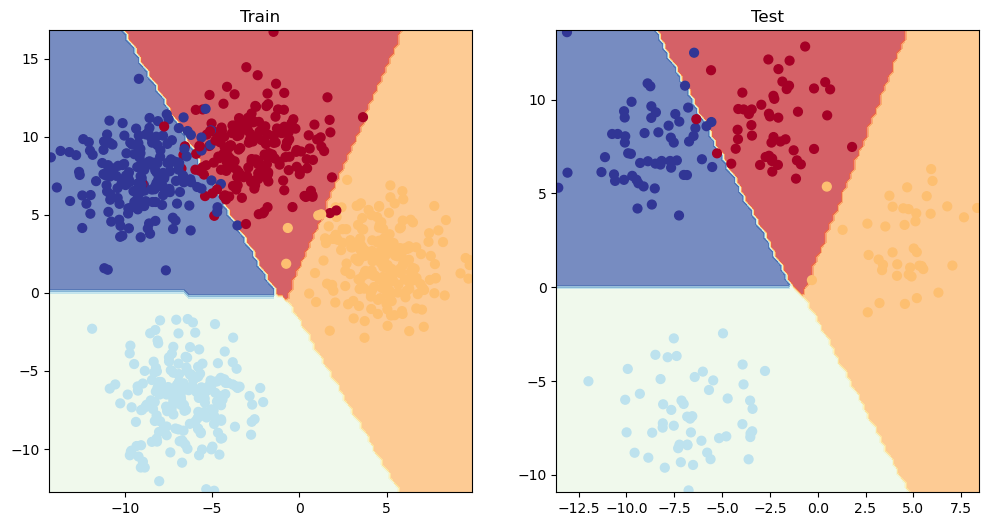

In [125]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)